# LCOS Calculator
This code is based on Methodology By O. Schmidt, S. Melchior, A. Hawkes, I. Staffell, Projecting the Future Levelized Cost of Electricity Storage Technologies, Joule 3 (1) (2019)81–100.doi:10.1016/j.joule.2018.12.008. 
The data table for technologies is listed in our paper (Table XXX) 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import matplotlib as mpl
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.figsize']



Table=pd.read_csv('CostData.csv',sep=';' ,index_col='Name', decimal=",") # Read Data Table 
Table=Table.iloc[:,2:]
Table

,Pumped Hydro,CAES (Adiabatic),Battery (Lithium-ion),Hydrogen,TES (Molten Salt),PTES (Rock),LEAS (Standalone)
Name,,,,,,,
Investment cost - Power,1129.0000,1200.000,156.000,2741.000,1341.000,1300.000,1700.000
Investment cost - Energy,80.0000,49.000,168.000,15.000,18.030,20.000,40.000
Operation cost - Power,8.0000,4.000,10.000,24.300,10.000,5.000,6.000
Operation cost - Energy,1.0000,5.000,3.000,1.000,3.500,5.000,4.000
Replacement cost,0.0000,0.000,0.000,0.000,0.000,0.000,0.000
Replacement interval,33250.0000,16250.000,3250.000,200000.000,30000.000,16250.000,16250.000
End-of-life cost,0.0000,0.000,0.000,0.000,0.000,0.000,0.000
Discount rate,0.0000,0.000,0.000,0.000,0.000,0.000,0.000
Round-trip efficiency,0.7800,0.550,0.900,0.400,0.450,0.550,0.500


### Required additional parameters

In [2]:
Pel=0.02  # Price of electricity per MWh 
CapnorP=1000; # Power Rating of 1 MW
DD=4# Duration of discharge
DoD=1 # Depth of Discharge
CapnomE=DD*CapnorP  # Storage Energy needed for DOD
Cycpa= 365 # Annual Cycles! 
r=0.07 # Discount Rate 
Table.loc['Shelf life']

Pumped Hydro             55.0
CAES (Adiabatic)         30.0
Battery (Lithium-ion)    13.0
Hydrogen                 18.0
TES (Molten Salt)        30.0
PTES (Rock)              30.0
LEAS (Standalone)        30.0
Name: Shelf life, dtype: float64

**Redefinations for table variables** 

In [3]:
CP=Table.loc['Investment cost - Power']
CE=Table.loc['Investment cost - Energy']
CPOM=Table.loc['Operation cost - Power']
CEOM=Table.loc['Operation cost - Energy']
RTE=Table.loc['Round-trip efficiency']
TDEG=Table.loc['Time degradation']
CDEG=Table.loc['Cycle degradation']
Effiidle=Table.loc['Self-discharge']
Tc=Table.loc['Construction time']
FEOL=Table.loc['End-of-life cost']
Cyclife=Table.loc['Lifetime']/Table.loc['Shelf life']
N=np.minimum(Table.loc['Shelf life'],Cyclife) # Life time is minimum of cycle life and self life

## LCOS Formula

$LCOS= \frac{Investmentcost+\sum_{n=1}^N \frac{O\&Mcost }{(1+r)^n}+\sum_{n=1}^N \frac{Charging cost }{(1+r)^n}}{\sum_{n=1}^N \frac{Discharge cost }{(1+r)^n}} = \frac{Investmentcost+\sum_{n=1}^N \frac{O\&Mcost }{(1+r)^n}}{\sum_{n=1}^N \frac{Discharge cost }{(1+r)^n}}+ \frac{Pel}{RTE}$

= $\frac{Investment Part+ O\&M part}{Discharge Part}+ \frac{Pel}{RTE} $

### Investment Cost
Replacement Cost and Replacement intreval is not used! 

Investment Part=$CP*CapnorP+CE*CapnomE$

In [4]:

InvestmentCost=CP*CapnorP+CE*CapnomE 


### O&M part
O&M cost accounts for power and energy specific operation and maintenance cost (CPOM, CEOM) relative to nominal power capacity and annual charged electricity.

$\sum_{n=1}^N \frac{O\&Mcost }{(1+r)^n} = \sum_{n=1}^N \frac{CPOM*CapnorP+CEOM (Cycpa*DoD*CapnomE)*(1-CDEG)^{(n-1)*Cycpa}(1-TDEG)^{n-1}}{(1+r)^{n}}$

In [5]:
OAM=[]
for i in range(len(N)):
    OAMp=sum((CPOM[i]*CapnorP+CEOM[i]/1000*(Cycpa*DoD*CapnomE)*(1-CDEG[i])**((n-1)*Cycpa)*(1-TDEG[i])**(n-1))/((1+r)**(n)) for n in range(0,int(N[i])))
    OAM.append(OAMp)
OAM=pd.Series(data=OAM, index=InvestmentCost.index.tolist())

### End of life part 
This is not used in this calculation

In [6]:
EndofLife=(CP*CapnorP+CE*CapnomE)*FEOL/(1+r)**(N+1)

### Self discharge
Self-discharge (effiself) for each technology and application is approximated by accounting for the daily self-discharge at idle state of the technology, and the application’s annual cycle and discharge duration (DD) requirement. This equation describes the maximum influence of self-discharge, assuming the device is always fully charged when idle between cycles. Minimum self discharge would occour when storage was fully discharged during idle operation. 

effiself=$Effiidle \frac{8760-2*Cycpa*DD}{Cycpa}$

In [7]:
effiself=Effiidle*(8760-2*Cycpa*DD)/Cycpa # 


### Discharge part
Discharged electricity accounts for annual cycles (Cycpa), nominal energy capacity (CapnomE), depth-of-discharge (DoD),round-trip efficiency (RTE), cycle degradation (CDEG), time degradation (TDEG), self-discharge (effiself), and construction time of the technology (Tc =0).

$\sum_{n=1}^N \frac{Discharge cost }{(1+r)^n} =Cycpa*DoD*CapnomE*RTE*(1-effiself)+ \sum_{n=1}^N \frac{(1-CDEG)^{(n-1)*Cycpa}*(1-TDEG)^{n-1}}{(1+r)^n} $


In [8]:
DischargeA=Cycpa*DoD*CapnomE*RTE*(1-effiself)
DischargeB=[]
for i in range(len(N)):
    DischargeBp=sum(((1-CDEG[i])**((n-1)*Cycpa)*(1-TDEG[i])**(n-1))/((1+r)**n) for n in range(0,int(N[i])))
    DischargeB.append(DischargeBp)
DischargeB=pd.Series(data=DischargeB, index=InvestmentCost.index.tolist())
Discharge=DischargeB*DischargeA

### The LCOS calculation 
LCOS= $\frac{Investment Part+ O\&M part}{Discharge Part}+ \frac{Pel}{RTE} $

In [9]:

LCOS2=(InvestmentCost+OAM)/Discharge+ Pel/RTE
LCOS2*1000 #(LCOS per MWh)


Pumped Hydro             119.693744
CAES (Adiabatic)         203.105671
Battery (Lithium-ion)    125.649318
Hydrogen                 622.275396
TES (Molten Salt)        281.469088
PTES (Rock)              218.663119
LEAS (Standalone)        279.653110
dtype: float64

# LCOS as a function of required additional parameters

This is the same code as shown above but now as a function!! 

In [10]:
def CostofStorage(CapnorP,Cycpa,DD,DoD,Pel,r):
    CapnomE=DD*CapnorP  # Storage Energy needed for DOD
    InvestmentCost=CP*CapnorP+CE*CapnomE 
    OAM=[]
    for i in range(len(N)):
        OAMp=sum((CPOM[i]*CapnorP+CEOM[i]/1000*(Cycpa*DoD*CapnomE)*(1-CDEG[i])**((n-1)*Cycpa)*(1-TDEG[i])**(n-1))/((1+r)**(n)) for n in range(0,int(N[i])))
        OAM.append(OAMp)
    OAM=pd.Series(data=OAM, index=InvestmentCost.index.tolist())
    effiself=Effiidle*(8760-2*Cycpa*DD)/Cycpa # 
    DischargeA=Cycpa*DoD*CapnomE*RTE*(1-effiself)
    DischargeB=[]
    for i in range(len(N)):
        DischargeBp=sum(((1-CDEG[i])**((n-1)*Cycpa)*(1-TDEG[i])**(n-1))/((1+r)**n) for n in range(0,int(N[i])))
        DischargeB.append(DischargeBp)
    DischargeB=pd.Series(data=DischargeB, index=InvestmentCost.index.tolist())
    Discharge=DischargeB*DischargeA
    LCOS=((InvestmentCost+OAM)/Discharge+ Pel/RTE)*1000
    return LCOS

In [11]:
LCOS=CostofStorage(1000,365,4,1,0,0.07)
LCOS  # Check the function !!

Pumped Hydro              94.052719
CAES (Adiabatic)         166.742035
Battery (Lithium-ion)    103.427096
Hydrogen                 572.275396
TES (Molten Salt)        237.024643
PTES (Rock)              182.299482
LEAS (Standalone)        239.653110
dtype: float64

 Loop over Cycles with DoD =1, Pel=0.02, r= 0.07

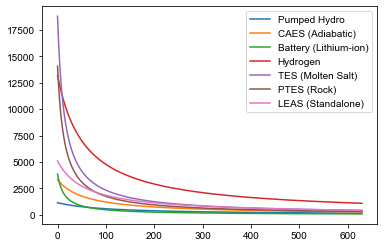

In [12]:
LCOSc=[]
Cycles=np.arange(100,365*2)
for i in Cycles: 
    LCOSSp=CostofStorage(1000,i,1,1,0.0,0.07)
    LCOSc.append(LCOSSp)
# Plot the results!
pd.DataFrame(LCOSc).plot()

Loop over duration of discharge 

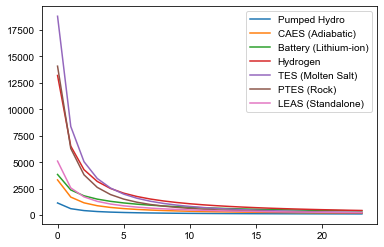

In [13]:
LCOSd=[]
DD=np.arange(1,25)
for i in DD: 
    LCOSSp=CostofStorage(1000,100,i,1,0.0,0.07)
    LCOSd.append(LCOSSp)
# Plot the results!
pd.DataFrame(LCOSd).plot()

## Surface plot for Cycles VS Discharge Duration

#### create surface to plot 

In [14]:
x = np.arange(1,400,2)  # x is cycles 
y = np.arange(50,0,-.25)   # y is Discharge duration   
X, Y = np.meshgrid(x, y)
# Cycle cannot be more than 8760/(DD*2) 
ind=X>(8760/(Y*3)) # For better Visual 

In [15]:
Cost=[]
for i in np.arange(len(X.flatten())):
    Costp=CostofStorage(10000,X.flatten()[i],Y.flatten()[i],1,0.0,0.07)
    Cost.append(Costp)

Remove unrealistic data

In [16]:
Z= np.reshape(Cost, (x.size,x.size,7)) 
Z[:,:,1].shape
Z[Z<0]='NaN'
Z[ind]='NaN'
X, Y = np.meshgrid(x, y)
cmap = matplotlib.cm.get_cmap("jet", 10)

### The figure 

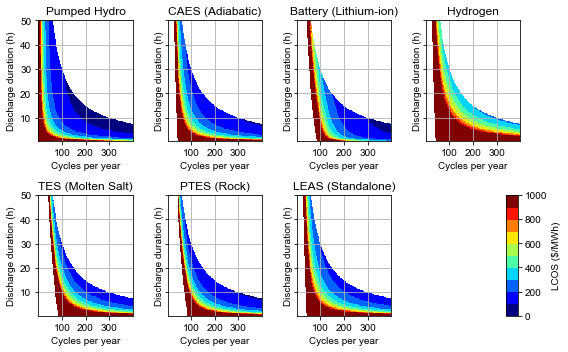

In [20]:
fig, axs = plt.subplots(2,4, figsize=(8, 5), facecolor='w', edgecolor='k', sharey=True, )
fig.subplots_adjust(hspace = .4, wspace=.4)
axs = axs.ravel()
Name=list(Table.columns)
for i in range(7):
    c=axs[i].pcolor(X, Y,Z[:,:,i], cmap=cmap,vmin=0, vmax=1000)
    axs[i].set_title(Name[i])
    axs[i].grid()
    #axs[i].set_xscale('log')
fig.colorbar( c,shrink=1, aspect=10, label='LCOS ($/MWh)')
for ax in axs:
    ax.set_xlabel('Cycles per year')
    ax.set_ylabel('Discharge duration (h)')

axs[7].set_axis_off()

plt.tight_layout()
plt.savefig('LCOS.png', dpi=600)
plt.show()